In [2]:
using Rocket
using Distributions
using ReactiveMP
using BenchmarkTools

import Base: show

In [3]:
function createSubgraph(model, index::Int)
    noise_add = make_node(model, +)
    
    noise = constvar(model, :noise, NormalMeanVariance(0.0, 200.0))
    yn    = datavar(model, :yn, Dirac{Float64})
    
    connect!(noise_add, :in2, noise)
    connect!(noise_add, :out, yn)
    
    return (yn, noise_add)
end

function createGraph(size::Int)    
    model = Model()
    
    c0_add = make_node(model, +)
    
    c0       = constvar(model, :c0, 1.0)
    x0_prior = datavar(model, :x0_prior, NormalMeanVariance{Float64})
    
    connect!(c0_add, :in1, x0_prior)
    connect!(c0_add, :in2, c0)
    
    index = 1
    
    prev_c_add = c0_add
    
    xs = Vector{RandomVariable}(undef, size)
    ys = Vector{DataVariable}(undef, size)
    
    while index < size
        yn, noise_add = createSubgraph(model, index)
        xn            = randomvar(model, :xn)
        
        c_add = make_node(model, +)
        cn    = constvar(model, :cn, 1.0)
        
        connect!(prev_c_add, :out, xn)
        connect!(noise_add, :in1, xn)
        connect!(c_add, :in1, xn)
        connect!(c_add, :in2, cn)
        
        activate!(model, prev_c_add)
        activate!(model, noise_add)
        
        xs[index] = xn
        ys[index] = yn
        
        prev_c_add = c_add
        
        index += 1
    end
    
    last_noise_add = make_node(model, +)
    
    x_last     = randomvar(model, :x_last)
    y_last     = datavar(model, :ylast, Dirac{Float64})
    last_noise = constvar(model, :last_noise, NormalMeanVariance(0.0, 200.0))
    
    connect!(prev_c_add, :out, x_last)
    connect!(last_noise_add, :in1, x_last)
    connect!(last_noise_add, :in2, last_noise)
    connect!(last_noise_add, :out, y_last)
    
    activate!(model)
    
    xs[size] = x_last
    ys[size] = y_last
    
    return (xs, ys, x0_prior)
end

createGraph (generic function with 1 method)

In [4]:
function smoothing(data)
    N = length(data)
    
    xs, ys, x_prior = createGraph(N);
    
    marginals     = Vector{NormalMeanVariance{Float64}}(undef, N)
    subscriptions = Vector{Teardown}(undef, N)
    
    for (index, x) in enumerate(xs)
        @inbounds subscriptions[index] = subscribe!(getmarginal(x), (d) -> marginals[index] = getdata(d))
    end
    
    update!(x_prior, NormalMeanVariance(0.0, 10000.0))
    for i in 1:N
       @inbounds update!(ys[i], data[i])
    end
    
    foreach(unsubscribe!, subscriptions)
    
    return marginals
end

smoothing (generic function with 1 method)

In [5]:
N = 750
data = collect(1:N) + sqrt(200.0) * randn(N);

In [6]:
@time smoothing(data); # Initial compilation

  3.196452 seconds (7.86 M allocations: 429.657 MiB, 8.38% gc time)


In [7]:
@time smoothing(data); # Subsequent runs

  0.075847 seconds (674.71 k allocations: 43.998 MiB, 32.60% gc time)


In [8]:
@btime smoothing($data); # Performance benchmark

  60.260 ms (674706 allocations: 44.00 MiB)


In [10]:
using Plots

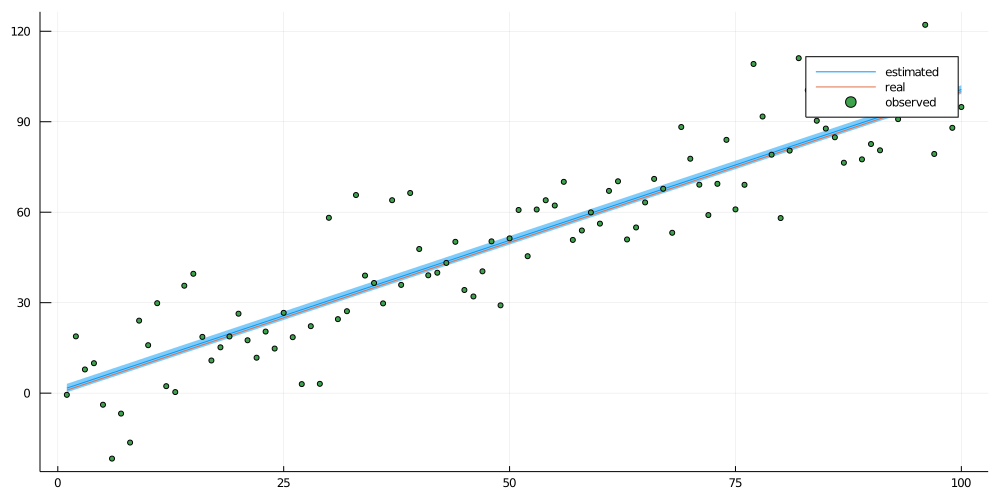

In [11]:
real_data = collect(1:100)
obs_data  = real_data .+ (sqrt(200.0) * randn(100));
estimated = smoothing(obs_data)

graph = plot(mean.(estimated), ribbon = std.(estimated), label = :estimated)
graph = plot!(graph, real_data, label = :real)
graph = scatter!(graph, obs_data, ms = 3, label = :observed)

plot(graph, size = (1000, 500))